# BirdBrain Data Wrangling and EDA

## Data Source:
ImageNet for transfer learning https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description
Kaggle Dataset: https://www.kaggle.com/gpiosenka/100-bird-species

## Problem Statement:
How can we identify the images of birds and the bird species with increasing photograph sets
produced by the current bird camera and the 5 to be added to the network?


Are all the images there?
Do any of the images need to be scaled?
Should I flip or rotate any images to increase training data?

In [1]:
#imports
import os
from os.path import exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage import io
from skimage import data
from skimage.util import compare_images

1. Are all the files in the in the directory structure as expected?
2. Are all the images the same size?
3. Should I flip or rotate any of the images?  Will that help with training by generating more images?

In [2]:
#constants
PROJECT_DATA_PATH = './Data/'
#image expected size
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [3]:
#helper functions
def imageSizedCorrectly(expectedHeight, expectedWidth, imagedata):
    if imagedata.shape[0] == expectedHeight and imagedata.shape[1] == expectedWidth and imagedata.shape[2] > 1:
        return True
    return False

def getImageData(imagePath):
    if exists(imagePath):
        return io.imread(imagePath)

def loadFilePointers(csvPath, dataset):
    if not exists(csvPath):
        raise Exception('File Not Found: ' + csvPath)
    csv = pd.read_csv(csvPath)
    return csv[csv["data set"] == dataset]
    
def showDuplicateImages(set1ImagePaths, set2ImagePaths):
    for idx in range(0, len(set1ImagePaths)):
        fig = plt.figure(figsize=(10, 5))
        ax1 = fig.add_subplot(idx+1, idx+2, 1)
        imgplot1 = plt.imshow(mpimg.imread(set1ImagePaths[idx]))
        ax1.set_title(set1ImagePaths[idx])
        ax2 = fig.add_subplot(idx+1, idx+2, 2)
        imgplot2 = plt.imshow(mpimg.imread(set2ImagePaths[idx]))
        ax2.set_title(set2ImagePaths[idx])
        plt.show()

In [4]:
trainDF = loadFilePointers(PROJECT_DATA_PATH + 'birds.csv', 'train')

In [5]:
print(trainDF.head())
print(trainDF.describe())


                             filepaths                 labels data set
0  train/AFRICAN CROWNED CRANE/001.jpg  AFRICAN CROWNED CRANE    train
1  train/AFRICAN CROWNED CRANE/002.jpg  AFRICAN CROWNED CRANE    train
2  train/AFRICAN CROWNED CRANE/003.jpg  AFRICAN CROWNED CRANE    train
3  train/AFRICAN CROWNED CRANE/004.jpg  AFRICAN CROWNED CRANE    train
4  train/AFRICAN CROWNED CRANE/005.jpg  AFRICAN CROWNED CRANE    train
                                  filepaths       labels data set
count                                 47332        47332    47332
unique                                47332          325        1
top     train/AFRICAN CROWNED CRANE/001.jpg  HOUSE FINCH    train
freq                                      1          249    47332


In [6]:
for idx, row in trainDF[['filepaths', 'labels']].iterrows():
    if not imageSizedCorrectly(IMAGE_HEIGHT, IMAGE_WIDTH, getImageData(PROJECT_DATA_PATH + row['filepaths'])):
        print(f"{row['labels']} has different size than expected for image: {row['filepaths']}")

In [7]:
#yay the training data has no incorrectly sized images in the data, no missing files the data looks clean.  
# Should do this again for the test and validation data sets.
testDF = loadFilePointers(PROJECT_DATA_PATH + "birds.csv", 'test')
print('TestDF: ', testDF.shape)
for idx, row in testDF[['filepaths', 'labels']].iterrows():
    if not imageSizedCorrectly(IMAGE_HEIGHT, IMAGE_WIDTH, getImageData(PROJECT_DATA_PATH + row['filepaths'])):
        print(f"{row['labels']} has different size than expected for image: {row['filepaths']}")
validDF = loadFilePointers(PROJECT_DATA_PATH + "birds.csv", 'valid')
print('ValidDF: ', validDF.shape)
for idx, row in validDF[['filepaths', 'labels']].iterrows():
    if not imageSizedCorrectly(IMAGE_HEIGHT, IMAGE_WIDTH, getImageData(PROJECT_DATA_PATH + row['filepaths'])):
        print(f"{row['labels']} has different size than expected for image: {row['filepaths']}")

TestDF:  (1625, 3)
ValidDF:  (1625, 3)


In [8]:
#huh... are the test and validation sets the exact same images or just the same size?
# need to remove the data set name from the file path to compare the image names.
# do I also need to compare images if the names are the same???
dataSetName = testDF.iloc[0]['data set']
testDF['filepaths'] = testDF['filepaths'].str.replace(dataSetName, '')
dataSetName = validDF.iloc[0]['data set']
validDF['filepaths'] = validDF['filepaths'].str.replace(dataSetName, '')

print(testDF.head(1))
print(validDF.head(1))

dfMergeIssues = testDF[['filepaths', 'labels']].merge(validDF[['filepaths', 'labels']], indicator=True, how='left').loc[lambda x : x['_merge'] == 'both']
print(dfMergeIssues.shape)
print(dfMergeIssues.head())

                          filepaths                 labels data set
47332  /AFRICAN CROWNED CRANE/1.jpg  AFRICAN CROWNED CRANE     test
                          filepaths                 labels data set
48957  /AFRICAN CROWNED CRANE/1.jpg  AFRICAN CROWNED CRANE    valid
(1625, 3)
                      filepaths                 labels _merge
0  /AFRICAN CROWNED CRANE/1.jpg  AFRICAN CROWNED CRANE   both
1  /AFRICAN CROWNED CRANE/2.jpg  AFRICAN CROWNED CRANE   both
2  /AFRICAN CROWNED CRANE/3.jpg  AFRICAN CROWNED CRANE   both
3  /AFRICAN CROWNED CRANE/4.jpg  AFRICAN CROWNED CRANE   both
4  /AFRICAN CROWNED CRANE/5.jpg  AFRICAN CROWNED CRANE   both


In [9]:
#they all have the same names lets just check them to see if they are exact matches.
countExactMatches = 0
testImages = []
validImages = []
arrMatches = []
for index, row in dfMergeIssues.iterrows():
    img1 = getImageData(PROJECT_DATA_PATH + 'test' + row['filepaths'])
    img2 = getImageData(PROJECT_DATA_PATH + 'valid' + row['filepaths'])
    if (np.sum(np.absolute(img1 - img2)) / (IMAGE_HEIGHT * IMAGE_WIDTH) / 255) == 0:
        testImages.append(PROJECT_DATA_PATH + 'test' + row['filepaths'])
        validImages.append(PROJECT_DATA_PATH + 'valid' + row['filepaths'])
        print(row['filepaths'], ' is an exact match.')
        arrMatches.append('valid' + row['filepaths']) #going to flip these horizontally.
        countExactMatches = countExactMatches + 1
        
print(F'Count of exact pixels matches: {countExactMatches}')

/DOUBLE BARRED FINCH/1.jpg  is an exact match.
/PINK ROBIN/4.jpg  is an exact match.
Count of exact pixels matches: 2


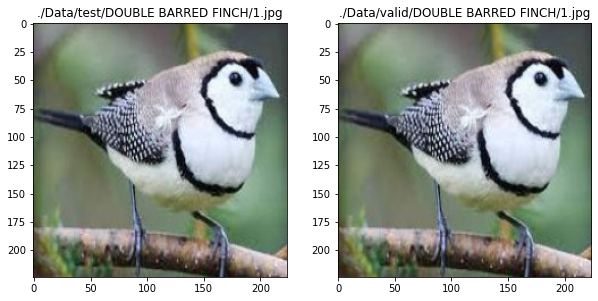

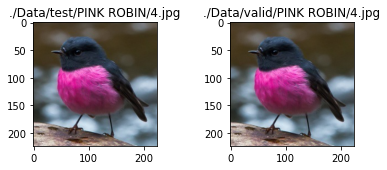

In [10]:
showDuplicateImages(testImages, validImages)


In [11]:
#they are identical... should I drop them or do I care that the test and validation sets share an image...
#  should I check for matches in the train set to prevent overfitting?
#maybe drop one from each.

#need to check the training data to the test and validation data sets.
for index, row in trainDF[['filepaths', 'labels']].iterrows():
    img1 = getImageData(PROJECT_DATA_PATH + row['filepaths'])
    for idx, r in testDF[testDF['labels'] == row['labels']][['filepaths', 'labels']].iterrows():
        img2 = getImageData(PROJECT_DATA_PATH + 'test' + r['filepaths'])
        if (np.sum(np.absolute(img1 - img2)) / (IMAGE_HEIGHT * IMAGE_WIDTH) / 255) == 0:
            print(F"{row['filepaths']} matches {r['filepaths']}")
            arrMatches.append(row['filepaths'])
            countExactMatches += 1


train/CAPE MAY WARBLER/100.jpg matches /CAPE MAY WARBLER/1.jpg
train/CAPE MAY WARBLER/142.jpg matches /CAPE MAY WARBLER/2.jpg
train/CAPE MAY WARBLER/143.jpg matches /CAPE MAY WARBLER/3.jpg
train/CAPE MAY WARBLER/144.jpg matches /CAPE MAY WARBLER/4.jpg
train/CAPE MAY WARBLER/145.jpg matches /CAPE MAY WARBLER/5.jpg
train/DOUBLE BARRED FINCH/005.jpg matches /DOUBLE BARRED FINCH/2.jpg
train/DOUBLE BARRED FINCH/011.jpg matches /DOUBLE BARRED FINCH/3.jpg
train/DOUBLE BARRED FINCH/033.jpg matches /DOUBLE BARRED FINCH/5.jpg
train/PINK ROBIN/019.jpg matches /PINK ROBIN/2.jpg
train/PINK ROBIN/021.jpg matches /PINK ROBIN/3.jpg
train/PINK ROBIN/039.jpg matches /PINK ROBIN/5.jpg
train/RED BROWED FINCH/002.jpg matches /RED BROWED FINCH/1.jpg
train/RED BROWED FINCH/026.jpg matches /RED BROWED FINCH/5.jpg


In [12]:
for index, row in trainDF[['filepaths', 'labels']].iterrows():
    img1 = getImageData(PROJECT_DATA_PATH + row['filepaths'])
    for idx, r in validDF[validDF['labels'] == row['labels']][['filepaths', 'labels']].iterrows():
        img2 = getImageData(PROJECT_DATA_PATH + 'valid' + r['filepaths'])
        if (np.sum(np.absolute(img1 - img2)) / (IMAGE_HEIGHT * IMAGE_WIDTH) / 255) == 0:
            print(F"{row['filepaths']} matches {r['filepaths']}")
            arrMatches.append(row['filepaths'])
            countExactMatches += 1


train/BLACK SKIMMER/007.jpg matches /BLACK SKIMMER/1.jpg
train/BLACK SKIMMER/010.jpg matches /BLACK SKIMMER/2.jpg
train/BLACK SKIMMER/014.jpg matches /BLACK SKIMMER/3.jpg
train/BLACK SKIMMER/023.jpg matches /BLACK SKIMMER/4.jpg
train/BLACK SKIMMER/024.jpg matches /BLACK SKIMMER/5.jpg
train/HORNED SUNGEM/015.jpg matches /HORNED SUNGEM/1.jpg
train/HORNED SUNGEM/023.jpg matches /HORNED SUNGEM/2.jpg
train/HORNED SUNGEM/028.jpg matches /HORNED SUNGEM/3.jpg
train/HORNED SUNGEM/038.jpg matches /HORNED SUNGEM/4.jpg
train/HORNED SUNGEM/050.jpg matches /HORNED SUNGEM/5.jpg
train/NORTHERN RED BISHOP/001.jpg matches /NORTHERN RED BISHOP/1.jpg
train/NORTHERN RED BISHOP/003.jpg matches /NORTHERN RED BISHOP/2.jpg
train/NORTHERN RED BISHOP/008.jpg matches /NORTHERN RED BISHOP/3.jpg
train/NORTHERN RED BISHOP/013.jpg matches /NORTHERN RED BISHOP/4.jpg
train/NORTHERN RED BISHOP/014.jpg matches /NORTHERN RED BISHOP/5.jpg
train/RED BELLIED PITTA/005.jpg matches /RED BELLIED PITTA/1.jpg
train/RED BELLIED PI

In [13]:
#take every matched image and flip it horizontally.

for img in arrMatches:
    img1 = getImageData(PROJECT_DATA_PATH + img)
    img2 = np.flip(img1, axis=1)
    if (np.sum(np.absolute(img1 - img2)) / (IMAGE_HEIGHT * IMAGE_WIDTH) / 255) != 0:
        io.imsave(PROJECT_DATA_PATH + img, img2)
        print(F"{img} has been flipped horizontally.")


valid/DOUBLE BARRED FINCH/1.jpg has been flipped horizontally.
valid/PINK ROBIN/4.jpg has been flipped horizontally.
train/CAPE MAY WARBLER/100.jpg has been flipped horizontally.
train/CAPE MAY WARBLER/142.jpg has been flipped horizontally.
train/CAPE MAY WARBLER/143.jpg has been flipped horizontally.
train/CAPE MAY WARBLER/144.jpg has been flipped horizontally.
train/CAPE MAY WARBLER/145.jpg has been flipped horizontally.
train/DOUBLE BARRED FINCH/005.jpg has been flipped horizontally.
train/DOUBLE BARRED FINCH/011.jpg has been flipped horizontally.
train/DOUBLE BARRED FINCH/033.jpg has been flipped horizontally.
train/PINK ROBIN/019.jpg has been flipped horizontally.
train/PINK ROBIN/021.jpg has been flipped horizontally.
train/PINK ROBIN/039.jpg has been flipped horizontally.
train/RED BROWED FINCH/002.jpg has been flipped horizontally.
train/RED BROWED FINCH/026.jpg has been flipped horizontally.
train/BLACK SKIMMER/007.jpg has been flipped horizontally.
train/BLACK SKIMMER/010.jpg

In [14]:
#no feature engineering as the pixels are the features.

dfClasses = pd.read_csv(PROJECT_DATA_PATH + 'class_dict.csv', index_col=0)

#the images are 224x224 not 150x150... don't want to reduce the quality so update the dataframe.
dfClasses['height'] = 224
dfClasses['width'] = 224

print(dfClasses.shape)
dfClasses.head(10)

(325, 4)


,class,height,width,scale by
class_index,,,,
0,AFRICAN CROWNED CRANE,224,224,1
1,AFRICAN FIREFINCH,224,224,1
2,ALBATROSS,224,224,1
3,ALEXANDRINE PARAKEET,224,224,1
4,AMERICAN AVOCET,224,224,1
5,AMERICAN BITTERN,224,224,1
6,AMERICAN COOT,224,224,1
7,AMERICAN GOLDFINCH,224,224,1
8,AMERICAN KESTREL,224,224,1


In [16]:
#classes and labels match, now sizes match.
dfClasses.to_csv(PROJECT_DATA_PATH + 'class_dict_updated.csv')